#### Data Preprocessing

In [48]:
import pandas as pd
import os
from openpyxl import load_workbook

In [49]:
df = pd.read_csv("questions.csv")

In [50]:
from bs4 import BeautifulSoup

In [51]:
def my_get_text(html_code):
    soup = BeautifulSoup(html_code)
    return soup.get_text().strip()
question_cleaned = df['Question'].apply(my_get_text)

In [52]:
df_noimage_mask = df[~df['Question'].str.contains("img")]

In [53]:
question_cleaned_noimg = df_noimage_mask['Question'].apply(my_get_text)


#### Open Router Question Maker

In [68]:
import requests
import json
# api_key = "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"
api_key = "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"

In [55]:
df_50_question = question_cleaned_noimg.sample(n=50,random_state=1)
df_50_question.reset_index(drop=True, inplace=True)

In [75]:
df_50_question.to_csv("50_questions.csv",index=False)

#### API request for specific model 

In [69]:
def ask_question_open_router(question,model):
    response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": f"Bearer {api_key}",
    "seed": "42",
  },
  data=json.dumps({
    "model": model, 
    "messages": [
      {"role": "user", "content": question }
    ]
  })
)
    response_data = response.json()
    messages = [choice['message']['content'] for choice in response_data['choices']]
    return messages

In [70]:
models = [
    "openai/gpt-3.5-turbo",
    "openai/gpt-4",
    "meta-llama/llama-2-70b-chat",
    "mistralai/mistral-7b-instruct",
    "anthropic/claude-3-opus",
    "google/gemini-pro",
    "mistralai/mixtral-8x7b-instruct:nitro",
    "mistralai/mistral-7b-instruct:nitro"
]
# Iterate through each model
for model in models:
    # Create an empty DataFrame to store the results for each model
    result = pd.DataFrame(index=range(50), columns=["Q1", "Q2", "Q3", "Q4"])
    print(f"Generating answers for {model}...")

    # Generate answers for Q1
    for i in range(50):
        question = ("Based on the following multiple-choice question, generate three plausible distractors "
                    "and one correct answer. Mark the correct answer with an (X), and no explanation ")+ df_50_question[i]
        messages = ask_question_open_router(question, model)
        result.at[i, 'Q1'] = messages[0]

    # Evaluate if the question is unambiguous for Q2
    for i in range(50):
        question = "Is the question an unambiguous exam question that has only one answer? " + df_50_question[i]
        messages = ask_question_open_router(question, model)
        result.at[i, 'Q2'] = "Y" if "YES" in messages[0].upper() else "N"

    # Rephrase ambiguous questions for Q3
    for i in range(50):
        if result.at[i, 'Q2'] == "N":
            question = "How would you rephrase the question to be unambiguous and suitable for a Multiple choice question on an exam? " + df_50_question[i]
            messages = ask_question_open_router(question, model)
            result.at[i, 'Q3'] = messages[0]
        else:
            result.at[i, 'Q3'] = "None"

    # Generate new answers for rephrased questions for Q4
    for i in range(50):
        if result.at[i, 'Q3'] != "None":
            question = (("Based on the following multiple-choice question, generate three "
                        "plausible distractors and one correct answer. Mark the correct answer with an (X), and no explanation ")+ df_50_question[i])
            messages = ask_question_open_router(question, model)
            result.at[i, 'Q4'] = messages[0]
        else:
            result.at[i, 'Q4'] = "None"

    
    file_path = os.path.join(output_dir, f"{model.split('/')[1]}.xlsx")
    result.to_excel(file_path, index=False)

    # Adjust column widths
    wb = load_workbook(file_path)
    ws = wb.active

    for column in ws.columns:
        max_length = 0
        column_letter = column[0].column_letter  # Get the column letter
        for cell in column:
            try:
                if cell.value:
                    max_length = max(max_length, len(str(cell.value)))
            except:
                pass
        adjusted_width = (max_length + 2) * 1.2  # Add some padding
        ws.column_dimensions[column_letter].width = adjusted_width

    for row in ws.iter_rows():
        max_height = 0
        for cell in row:
            if cell.value:
                lines = str(cell.value).split('\n')
                cell_height = len(lines) * 15  # Approximate row height per line
                if cell_height > max_height:
                    max_height = cell_height
        ws.row_dimensions[row[0].row].height = max_height

    wb.save(file_path)

print("Completed generating answers for all models.")


Generating answers for google/gemini-pro...
Generating answers for mistralai/mixtral-8x7b-instruct:nitro...
Generating answers for mistralai/mistral-7b-instruct:nitro...
Completed generating answers for all models.


In [96]:
claude3 = pd.read_excel("checked/claude3.xlsx")
gemini = pd.read_excel("checked/gemini.xlsx")
gpt3 = pd.read_excel("checked/gpt3.5.xlsx")
gpt4 = pd.read_excel("checked/gpt4.xlsx")
llama = pd.read_excel("checked/llama.xlsx")
mistral7bi = pd.read_excel("checked/mistral7binstruct.xlsx")
mistral7bin = pd.read_excel("checked/mistral7binstructnitro.xlsx")
mistral8x7bin = pd.read_excel("checked/mistral8x7binstructnitro.xlsx")


In [100]:
claude3.head()

,Q1,Q2,Q3,Q4
0,1,N,1.0,1.0
1,0,N,1.0,0.0
2,1,N,1.0,1.0
3,0,Y,NaN,NaN
4,1,Y,NaN,NaN


In [99]:
# create a multiple models dataframe
models = [claude3, gemini, gpt3, gpt4, llama, mistral7bi, mistral7bin, mistral8x7bin]
model_names = ["claude3", "gemini", "gpt3.5", "gpt4", "llama", "mistral7bi", "mistral7bin", "mistral8x7bin"]

claude3              gemini              gpt3.5     ... mistral7bi       \
       Q1 Q2   Q3   Q4     Q1 Q2   Q3   Q4     Q1 Q2  ...         Q3   Q4   
0       1  N  1.0  1.0      1  N  1.0  1.0      0  N  ...        NaN  NaN   
1       0  N  1.0  0.0      0  N  1.0  0.0      0  Y  ...        1.0  0.0   
2       1  N  1.0  1.0      1  N  1.0  1.0      0  N  ...        1.0  1.0   
3       0  Y  NaN  NaN      0  N  1.0  0.0      1  N  ...        1.0  0.0   
4       1  Y  NaN  NaN      1  N  1.0  1.0      1  Y  ...        1.0  1.0   

  mistral7bin              mistral8x7bin               
           Q1 Q2   Q3   Q4            Q1 Q2   Q3   Q4  
0           1  N  1.0  1.0             1  N  1.0  1.0  
1           1  N  1.0  1.0             0  Y  NaN  NaN  
2           1  N  1.0  1.0             1  N  1.0  1.0  
3           0  N  1.0  0.0             0  Y  NaN  NaN  
4           1  N  1.0  1.0             1  Y  NaN  NaN  

[5 rows x 32 columns]

In [111]:
model_correct = pd.DataFrame(index=model_names,columns=['% Correct','% ambiguous','%correct after revised'])

for i in model_names:
    model_correct.at[i,'% Correct'] = models[model_names.index(i)]['Q1'].sum()/50
    model_correct.at[i,'% ambiguous'] = models[model_names.index(i)]['Q2'].value_counts(normalize=True)['N']
    model_correct.at[i,'%correct after revised'] = models[model_names.index(i)]['Q4'].sum()/models[model_names.index(i)]['Q2'].value_counts()['N']

model_correct


,% Correct,% ambiguous,%correct after revised
claude3,0.64,0.58,0.793103
gemini,0.56,0.86,0.674419
gpt3.5,0.64,0.74,0.540541
gpt4,0.7,0.44,0.818182
llama,0.62,0.9,0.666667
mistral7bi,0.5,0.92,0.5
mistral7bin,0.56,0.98,0.612245
mistral8x7bin,0.62,0.68,0.676471


TypeError: Axes.boxplot() got an unexpected keyword argument 'y'

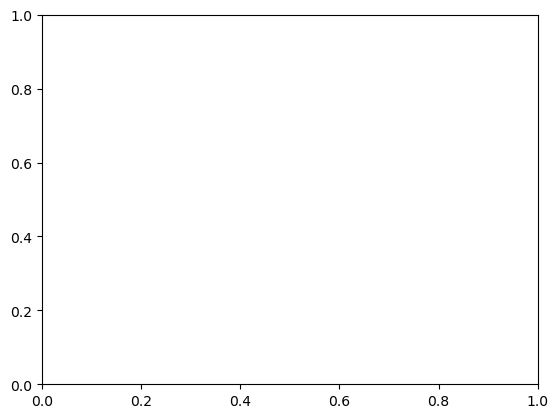

In [162]:
Question_Accuracy = pd.DataFrame(columns=model_names)

for i in model_names:
    Question_Accuracy[i] = models[model_names.index(i)]['Q1']
df = pd.DataFrame(columns=model_names)
for i in model_names:
    df[i] = models[model_names.index(i)]['Q2'].apply(lambda x: 1 if x == 'N' else 0)
Question_Accuracy['Average'] = Question_Accuracy.mean(axis=1)
Question_Accuracy['unambiguous'] = df.sum(axis=1)
Question_Accuracy.drop(columns=model_names,inplace=True)



# fig, ax1 = plt.subplots(figsize=(10,5))
# ax2 = ax1.twinx()
# Question_Accuracy['Average'].plot(kind='line',color='red',ax=ax1)
# Question_Accuracy['unambiguous'].plot(kind='bar',color='blue',ax=ax2)
# ax1.set_ylabel('Average Accuracy')
# ax2.set_ylabel('Unambiguous Questions')

Question_Accuracy.boxplot(y='Average',x='unambiguous')
